In [779]:
import pandas as pd
import matplotlib.pyplot as mp
import numpy as np
import glob

In [780]:
df = None

for name in glob.glob('test_with_backup_and_byzantine_node_ramp_up_*'):
    if df is None:
        df = pd.read_json(name)
    else:
        df = df.append(pd.read_json(name))

df = df.replace(np.nan,0)
df.shape


(3069, 11)

In [781]:
# filter out the requests that timed out

df = df[df["avg_duration"]> 0.0] 

In [782]:
df

,client_request,view_change,new_view,pre_prepare,prepare,commit,send_response,byzantine_node_cnt,backup_cnt,avg_duration,idx
0,29,81.0,9.0,153.0,1224.0,1377.0,153.0,1,9,12.275021,0
1,1,0.0,0.0,9.0,72.0,81.0,9.0,1,9,0.010898,1
2,1,0.0,0.0,9.0,72.0,81.0,9.0,1,9,0.018305,2
3,32,100.0,10.0,190.0,1710.0,1900.0,190.0,1,10,14.721102,0
4,32,100.0,10.0,190.0,1710.0,1900.0,190.0,1,10,12.397592,1
...,...,...,...,...,...,...,...,...,...,...,...
94,20,288.0,18.0,36.0,576.0,612.0,34.0,2,18,4.106505,1
95,1,0.0,0.0,18.0,288.0,306.0,17.0,2,18,0.042461,2
96,56,304.0,19.0,589.0,8835.0,9424.0,496.0,4,19,14.285789,0
97,1,0.0,0.0,19.0,247.0,266.0,14.0,6,19,0.119602,1


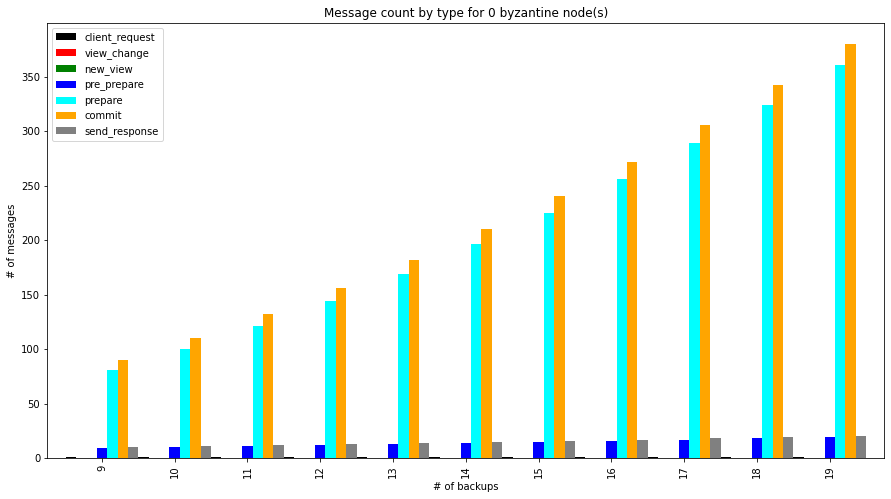

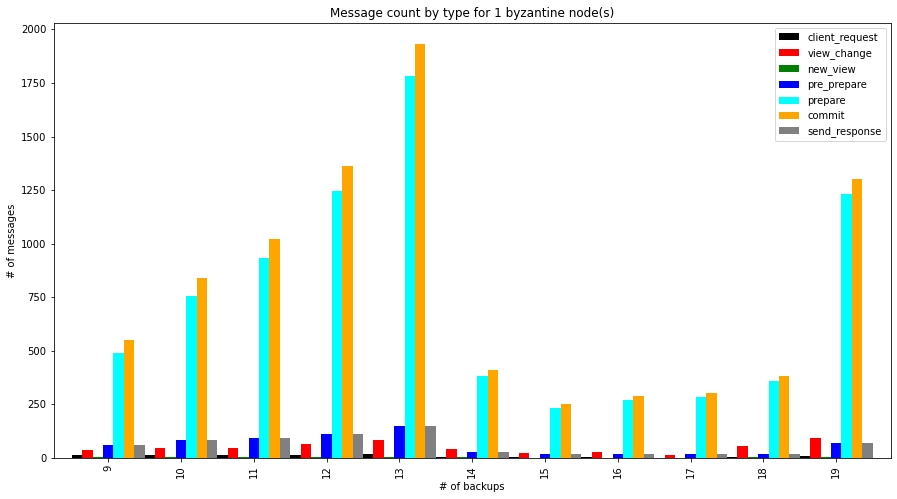

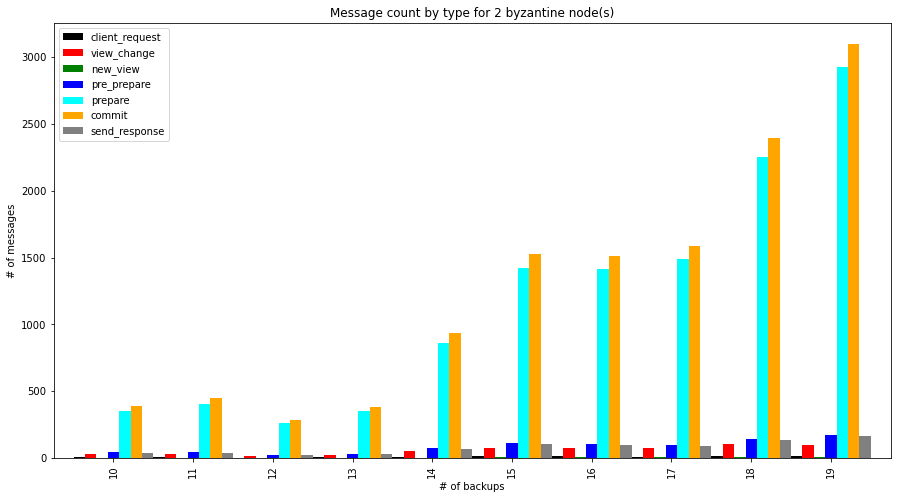

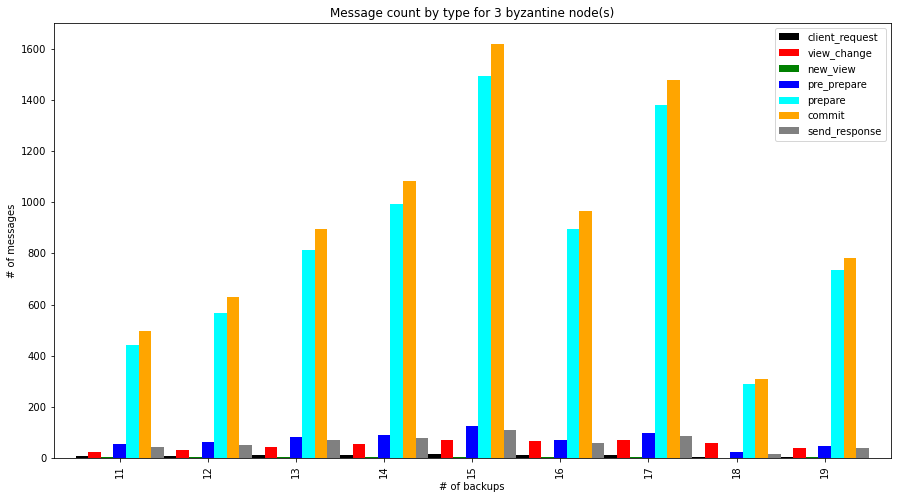

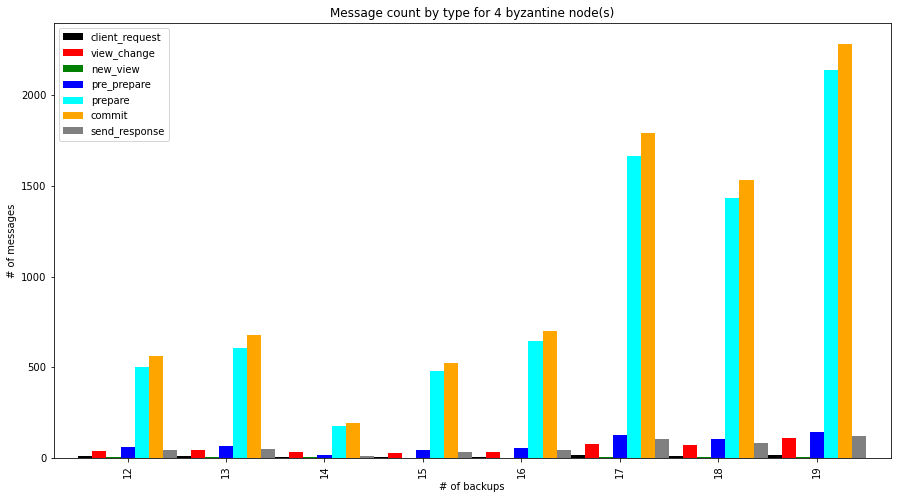

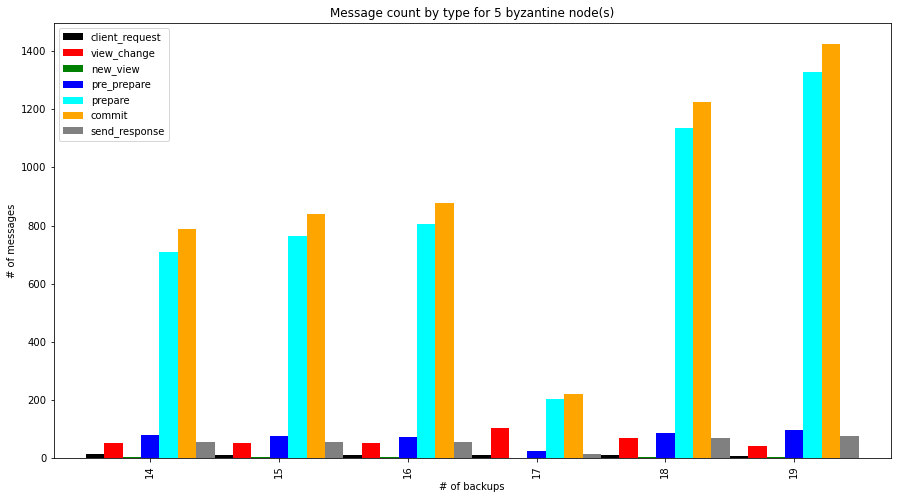

In [783]:
for i in range(6):
    df1 = df[df["byzantine_node_cnt"] == i]
    # noticed extremely rare cases where due to time lags a primary was declared as faulty.
    if i == 0:
        df1 = df1[df1["view_change"] == 0]


    df1 = df1.groupby(by=["backup_cnt"], dropna=False).mean()
    df1 = df1.reset_index()

    df1.plot(x ='backup_cnt', y=['client_request', 'view_change', 'new_view', 'pre_prepare', 'prepare', 'commit', 'send_response'], kind = 'bar', 
    title='Message count by type for {} byzantine node(s)'.format(i), xlabel = '# of backups', ylabel='# of messages', figsize=(15, 8),
    color=['black', 'red', 'green', 'blue', 'cyan', 'orange', 'grey'], width=1.0, labelsize=20)

    # df1.plot(x ='backup_cnt', y='avg_duration', kind='line')

In [784]:
START = 15
END = 19
FORMAT_STR = '{} replicas'

df2 = df[df["backup_cnt"] == START].groupby(by=["byzantine_node_cnt"], dropna=False).mean()
df2 = df2.reset_index()
df2 = df2[["byzantine_node_cnt", "avg_duration"]]
df2 = df2.rename(columns={'avg_duration':FORMAT_STR.format(START)})

for i in range(START + 1, END):
    df3 = df[df["backup_cnt"] == i].groupby(by=["byzantine_node_cnt"], dropna=False).mean()
    new_name = FORMAT_STR.format(i)
    df3 = df3.rename(columns={'avg_duration':new_name})
    extracted_col = df3[new_name]
    df2 = df2.join(extracted_col)

<AxesSubplot:title={'center':'Response times by # of replicas and # of byzantine nodes'}, xlabel='# of byzantine nodes', ylabel='Duration(seconds)'>

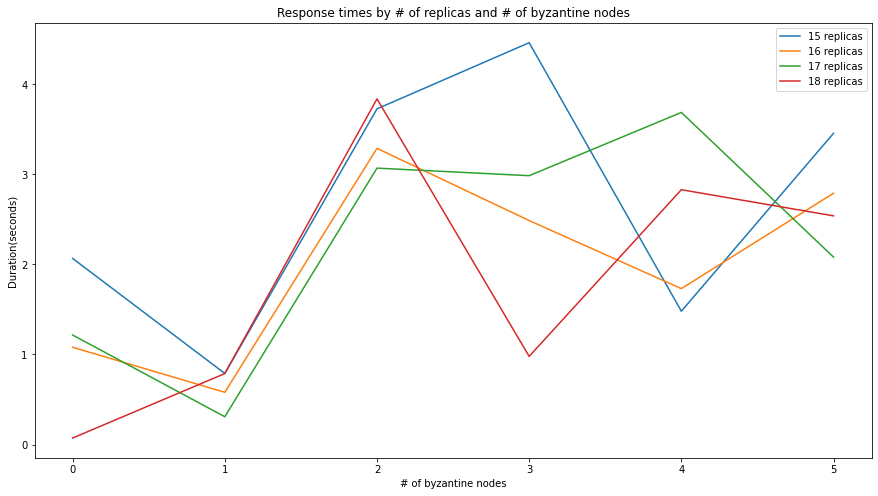

In [785]:
columns = [FORMAT_STR.format(i) for i in range(START, END)]

df2.plot(kind = 'line', x='byzantine_node_cnt', y=columns,
    title='Response times by # of replicas and # of byzantine nodes', xlabel = '# of byzantine nodes', ylabel='Duration(seconds)', figsize=(15, 8))

In [786]:
# test_with_fixed_backup_and_byzantine_node_ramp_up_1653852736

df4 = None

for name in glob.glob('test_with_fixed_backup_and_byzantine_node_ramp_up_*'):
    if df4 is None:
        df4 = pd.read_json(name)
    else:
        df4 = df4.append(pd.read_json(name))

df4 = df4.replace(np.nan,0)
df4.shape


(5640, 12)

In [787]:
# duration == -1 for the requests that timed out
df5 = df4[df4['avg_duration'] == -1].groupby(by=["byzantine_node_cnt"], dropna=False).count()[['client_request']].rename(columns={'client_request':'failed_requests'})
df6 = df4[df4['avg_duration'] != -1].groupby(by=["byzantine_node_cnt"], dropna=False).count()[['client_request']].rename(columns={'client_request':'successful_requests'})

In [788]:
index = df5.index.union(df6.index)
df5 = df5.reindex(index)
df7 = df5.join(df6)
df7 = df7.replace(np.nan,0)
df7['percent_failed'] = df7['failed_requests']/df7['successful_requests']

In [789]:
print(df7)

                    failed_requests  successful_requests  percent_failed
byzantine_node_cnt                                                      
0                               0.0               1033.0        0.000000
1                               0.0               1500.0        0.000000
2                              19.0               1242.0        0.015298
3                             361.0                841.0        0.429251
4                             511.0                  0.0             inf
5                             114.0                  0.0             inf
6                              16.0                  0.0             inf
7                               3.0                  0.0             inf
